In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import cohen_kappa_score

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import multiprocessing

### Training data preparation

In [3]:
data = pd.read_csv('./data/train_data.csv')
label = pd.read_csv('./data/train_label.csv')

In [4]:
data['label'] = label['label']
data.head()

,desc,tweet,label
0,none,mariotti did your ancestors have to apply thro...,0
1,usmc veteran love god wife family dog and coun...,rule of law all the liberals including her wan...,0
2,none,rt japanmissionun thank you unicef unhcr nyoff...,0
3,we ve been referring people to law firms since...,know a good law firm in stirling immigration c...,0
4,i love life i love my family i love people,wall street ally with a skepticism of immigrat...,0


In [5]:
data.isnull().sum()

desc     27
tweet     0
label     0
dtype: int64

In [6]:
data = data.dropna().reset_index(drop = True)
data.isnull().sum()

desc     0
tweet    0
label    0
dtype: int64

In [7]:
data.shape

(3929, 3)

In [8]:
X = data['desc'] + ' ' + data['tweet']
Y = data['label']

In [9]:
X.shape, Y.shape

((3929,), (3929,))

### Classification data praparation

In [10]:
_classification_data = pd.read_csv('./data/test_data.csv')

In [11]:
_classification_data = _classification_data.dropna().reset_index(drop = True)
_classification_data.shape

(819, 2)

In [12]:
classification_data = _classification_data['text']
classification_labels = _classification_data['label']

### Preparing feature extraction models

In [13]:
def tokenize(text):
    return [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]

In [14]:
%%time
vectorizer = TfidfVectorizer(tokenizer = tokenize)
vectorized_data = vectorizer.fit_transform(X)
classification_data = vectorizer.transform(classification_data)

Wall time: 1min 39s


In [15]:
%%time
tagged_data = [TaggedDocument(words = tokenize(_d), tags=[str(i)]) for i, _d in enumerate(X)]

Wall time: 1min 28s


In [16]:
cores = multiprocessing.cpu_count()

In [17]:
%%time
d2v_dm = Doc2Vec(tagged_data, dm=1, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
d2v_dbow = Doc2Vec(tagged_data, dm=0, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

Wall time: 7min 15s


### Preparing methods to evaluate and store results

In [18]:
results = dict()
cross_val = dict()

In [19]:
def eval(clf_name, feat, y_test, predictions):
    scores = dict()
    
    if clf_name not in results:
        results[clf_name] = {'accuracy': [],
                             'macro_precision': [], 'macro_recall': [], 'macro_f1': [],
                             'micro_precision': [], 'micro_recall': [], 'micro_f1': []}
    
    results[clf_name]['accuracy'].append(accuracy_score(y_test, predictions))

    results[clf_name]['macro_precision'].append(precision_score(y_test, predictions, average='macro'))
    results[clf_name]['macro_recall'].append(recall_score(y_test, predictions, average='macro'))
    results[clf_name]['macro_f1'].append(f1_score(y_test, predictions, average='macro'))

    results[clf_name]['micro_precision'].append(precision_score(y_test, predictions, average='micro'))
    results[clf_name]['micro_recall'].append(recall_score(y_test, predictions, average='micro'))
    results[clf_name]['micro_f1'].append(f1_score(y_test, predictions, average='micro'))

In [20]:
def cross(clf, clf_name, feat, X_train, Y_train):
    kf = KFold(n_splits=10, random_state = 42, shuffle = True)
    scores = cross_val_score(clf, X_train, Y_train, cv = kf)
    
    if clf_name not in cross_val:
        cross_val[clf_name] = {feat: scores}
    else:
        cross_val[clf_name].update({feat: scores})

In [21]:
preds = dict()

In [22]:
def pred(clf_name, predictions):
    preds[clf_name] = predictions

In [23]:
classification_acc = dict()
classification_pre = dict()
classification_rec = dict()
classification_f1 = dict()

In [24]:
def classify(clf, clf_name): 
    predictions = clf.predict(classification_data)
    
    acc = accuracy_score(classification_labels, predictions)
    pre = precision_score(classification_labels, predictions, average='macro')
    rec = recall_score(classification_labels, predictions, average='macro')
    f1 = f1_score(classification_labels, predictions, average='macro')
    
    classification_acc[clf_name] = acc
    classification_pre[clf_name] = pre
    classification_rec[clf_name] = rec
    classification_f1[clf_name] = f1
    
    pred(clf_name, predictions)

### Preparing methods for training and classification purpose

In [25]:
def split(X, Y):
    return train_test_split(X, Y, test_size = .4, shuffle = False)

In [26]:
def resample(d, l):
    sm = SMOTE(random_state=42, ratio=1.0)
    return sm.fit_sample(d, l)

In [27]:
def train_tfidf(clf, clf_name, X, Y):
    X_train, X_test, Y_train, Y_test = split(X, Y)
    X_train, Y_train = resample(X_train, Y_train)
    
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    
    cross(clf, clf_name, feats[0], X_train, Y_train)
    eval(clf_name, feats[0], Y_test, predictions)
    
    # In former runs, we identified that TF-IDF gives best results compared to PV-DM and PV-DBOW. Therefore, we will only perform classification using TF-IDF method.
    classify(clf, clf_name)

In [28]:
def train_d2v(model, feat, clf, clf_name, X, Y):
    X_train, X_test, Y_train, Y_test = split(X, Y)
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(X_train.shape[0]):
        x_train.append(model[str(i)])
        y_train.append(Y_train[i])
    
    for i in range(X_test.shape[0]):
        x_test.append(model[str(i + X_train.shape[0])])
        y_test.append(Y_test[i + X_train.shape[0]])
        
    x_train, y_train = resample(x_train, y_train)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    
    cross(clf, clf_name, feat, x_train, y_train)
    eval(clf_name, feat, y_test, predictions)

### Training and classification

In [29]:
clfs = [DecisionTreeClassifier(), SVC(), RandomForestClassifier(), BernoulliNB()]
clf_names = ['Decision Trees', 'Support Vector Machine', 'Random Forest', 'Naive Bayes']

In [30]:
feats = ['TF-IDF', 'PV-DM', 'PV-DBOW']

In [31]:
%%time
for i in range(len(clfs)):
    train_tfidf(clfs[i], clf_names[i], vectorized_data, Y)
    train_d2v(d2v_dm, feats[1], clfs[i], clf_names[i], X, Y)
    train_d2v(d2v_dbow, feats[2], clfs[i], clf_names[i], X, Y)

Wall time: 7min 53s


### Just printing and ploting everything we have got!

In [32]:
for c in results:
    print('\nClassifier: {}'.format(c))
    print('\n\t\t\t{}\t\t{}\t\t{}\n'.format(feats[0], feats[1], feats[2]), '-' * 64)
    for s in results[c]:
        print('{:20s}:\t{:f}\t{:f}\t{:f}'.format(s, results[c][s][0], results[c][s][1], results[c][s][2]))


Classifier: Decision Trees

			TF-IDF		PV-DM		PV-DBOW
 ----------------------------------------------------------------
accuracy            :	0.830789	0.680662	0.650127
macro_precision     :	0.670789	0.514719	0.502529
macro_recall        :	0.715115	0.524054	0.504404
macro_f1            :	0.687734	0.505266	0.485076
micro_precision     :	0.830789	0.680662	0.650127
micro_recall        :	0.830789	0.680662	0.650127
micro_f1            :	0.830789	0.680662	0.650127

Classifier: Support Vector Machine

			TF-IDF		PV-DM		PV-DBOW
 ----------------------------------------------------------------
accuracy            :	0.890585	0.138677	0.138677
macro_precision     :	0.788498	0.069338	0.069338
macro_recall        :	0.695947	0.500000	0.500000
macro_f1            :	0.728908	0.121788	0.121788
micro_precision     :	0.890585	0.138677	0.138677
micro_recall        :	0.890585	0.138677	0.138677
micro_f1            :	0.890585	0.138677	0.138677

Classifier: Random Forest

			TF-IDF		PV-DM		PV-DBOW
 ---------

In [33]:
def bar_plot(clf_name, scores):
    index = np.arange(len(feats))
    plt.barh(index, scores, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
    plt.xlabel('Recall', fontsize = 10)
    plt.ylabel('Feature extraction method', fontsize = 10)
    plt.yticks(index, feats, fontsize = 10)
    plt.gcf().subplots_adjust(left = 0.25)
    plt.title(clf_name)
    plt.savefig('_'.join(clf_name.split()).lower() + '_acc.png')
    plt.show()

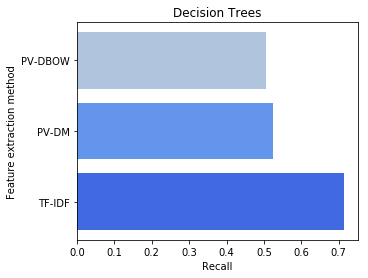

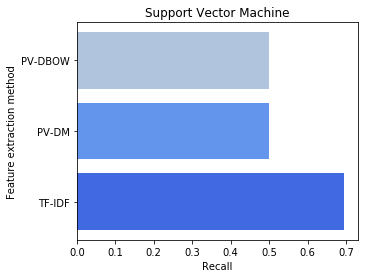

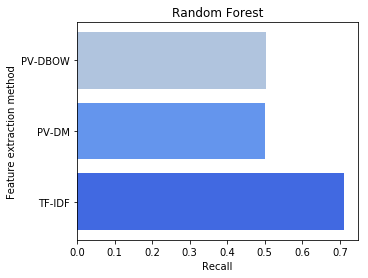

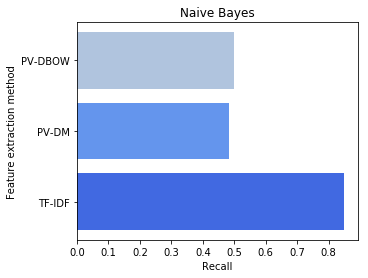

In [34]:
for c in results:
    clf_name = c
    scores = [results[c]['macro_recall'][0], results[c]['macro_recall'][1], results[c]['macro_recall'][2]]
    bar_plot(clf_name, scores)

In [35]:
def fold_plot(clf_name):
    plt.xlabel('Fold as test set')
    plt.ylim(0.4, 1)
    plt.ylabel('Score')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['TF-IDF'], color='blue')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['PV-DM'], color='red', linestyle='dashed')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['PV-DBOW'], color='green', linestyle='dotted')
    plt.legend(['TF-IDF', 'PV-DM', 'PV-DBOW'], loc='best')
    plt.title(clf_name)
    plt.savefig('_'.join(clf_name.split()).lower() + '_fold.png')
    plt.show()

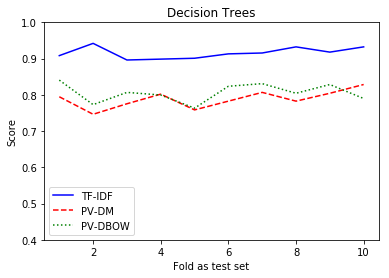

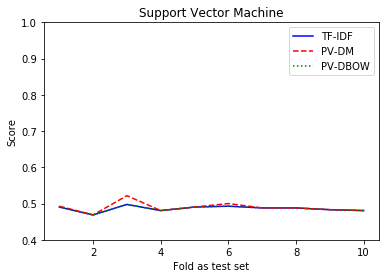

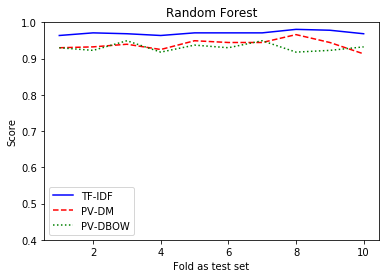

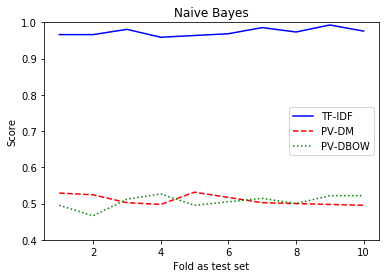

In [36]:
for c in cross_val:
    fold_plot(c)

In [37]:
print('Classification evaluation:\n\t\t\t\tAccuracy\tPrecision\tRecall\t\tF1\n', '-' * 90)
for clf in clf_names:
    print('{:20s}\t:\t{:f}\t{:f}\t{:f}\t{:f}'.format(clf, classification_acc[clf], classification_pre[clf], classification_rec[clf], classification_f1[clf]))

Classification evaluation:
				Accuracy	Precision	Recall		F1
 ------------------------------------------------------------------------------------------
Decision Trees      	:	0.829060	0.661598	0.691135	0.673831
Support Vector Machine	:	0.875458	0.745654	0.651904	0.681687
Random Forest       	:	0.903541	0.858889	0.693953	0.742080
Naive Bayes         	:	0.881563	0.754572	0.806196	0.776165


### Calculating Cohen-Kappa score between actual and predicted classification labels

In [38]:
print('Classifier\t\t\tC-K Score\n', '-' * 42)
for c in clf_names:
    p = preds[c].tolist()
    ck = cohen_kappa_score(classification_labels, p)
    print('{:20s}\t:\t{:f}'.format(c, ck))

Classifier			C-K Score
 ------------------------------------------
Decision Trees      	:	0.348915
Support Vector Machine	:	0.368915
Random Forest       	:	0.490756
Naive Bayes         	:	0.553387
